<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT21/blob/leobergman/LeoBergman_Lab4_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Iterative methods**
**Leo Bergman**

# **Abstract**

In this lab I performed some experiments with function approximation. There many of those, in this lab I tried out the L2 norm in Hilbert space, which is the best possible approximation.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [7]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Leo Bergman (bergmanleo@gmail.com)
# Template by Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [8]:
# Load neccessary modules.


from google.colab import files
from scipy.sparse import random
import time
import timeit
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib import tri, axes
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.sparse as sparse
from scipy import stats, integrate
import scipy
import numpy as np
from numpy.linalg import inv,norm,solve,lstsq,det
import unittest
from functools import reduce
from numpy.polynomial import polynomial as Poly
from scipy.spatial import Delaunay
#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common 
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *
    
#import dolfin.common.plotting as fenicsplot


# **Introduction**

In this lab I have tried out approximations of functions using a piece wise linear, the best of those namely the L2 norm.

---
Problems to solve:


1. Function: L2 projection to pw linear approximation over mesh in 1D

Input: function f(x), 1D mesh with nodes (x0,...,xn)
Output: vector of L2 projection of f(x) evaluated in (x0,...,xn) 
Test: verify accuracy and convergence rate against exact function

2. Function: L2 projection to pw linear approximation over triangular mesh in 2D

Input: function f(x), triangular mesh data structure with nodes (x0,...,xn)
Output: vector of L2 projection of f(x) evaluated in (x0,...,xn) 
Test: verify accuracy and convergence rate against exact function

$h_i$ is the interval length of interval $I_i$

# **Method**

For the mesh we will have one and only one basis function defined in one node in the mesh such that 

$\phi_i (x_i) = 1$

In each iteration over the basis functions we calculate the inner products to add the results to the vector $b_i = (f,\phi_i)$ and similar for A:

$a_{ij} = (\phi_j,\phi_i)$

where the elements $a_{ij}$ fills up the matrix A.

Why do we do this at all? Well to solve the equation system 
$Ax = b$

Easy as that.

Anyway, going further we have that 

$(\phi_i,\phi_j) = 0$ 

if $|j-i|$ is strictly larger than 1 in other cases we have that

$(\phi_i,\phi_i) = h/3$

$(\phi_i,\phi_{i+1}) = h/6$


In [9]:
def meshgen(dim,meshdim,xlen=10,ylen=10,zlen=10):
  if dim == 1:
    X = np.linspace(0,xlen,num = meshdim)
    return X

  elif dim == 2:
    X = np.zeros((meshdim*meshdim))
    Y = np.zeros((meshdim*meshdim))
    for i in range(meshdim):
      for j in range(meshdim):
        X[i*meshdim+j] = i*xlen/ (meshdim-1)
        Y[i*meshdim+j] = j*ylen/(meshdim-1)
    return Delaunay(np.vstack((X,Y)).T) #triangulation of those

        

In [10]:
class L2:

  def __init__(self, mesh,n,dim):
    self.mesh = mesh
    self.dim = dim
    self.n = n
    self.globalM = np.zeros((n,n))
    self.globalb = np.zeros((n))

  def assemble_system(self, f):
    if self.dim == 1:
      for k in range(0,self.n-1):
        q = 1 #number of quadrature points
        A = np.zeros((q+1,q+1))
        b = np.zeros((q+1))
        for i in range(q+1):
          b[i] = self.integrate_vector(f,k,i)
          for j in range(q+1):
            A[i,j] = self.integrate_matrix(k,i,j)
        self.add_to_global_vector(b,k)
        self.add_to_global_matrix(A,k)

    if self.dim == 2:
      for k in range(0,self.n-1):
        q = 1 #number of quadrature points
        A = np.zeros((q+1,q+1))
        b = np.zeros((q+1))
        for i in range(q+1):
          b[i] = self.integrate_vector(f,k,i)
          for j in range(q+1):
            A[i,j] = self.integrate_matrix(k,i,j)
            #Hard stuff!
        self.add_to_global_vector(b,k)
        self.add_to_global_matrix(A,k)

  def integrate_matrix(self,k, i, j):
    h = abs(self.mesh[k] - self.mesh[k+1])
    if i == j:
      return h/3
    elif abs(j-i) == 1:
      return h/6


  def integrate_vector(self, f, k, i):
    h = abs(self.mesh[k] - self.mesh[k+1])
    if i == 0:
      return integrate.quad(lambda x: f(x) * (self.mesh[k+1] - x) / h, self.mesh[k], self.mesh[k+1])[0]
    elif i == 1:
      return integrate.quad(lambda x: f(x) * (x - self.mesh[k]) / h , self.mesh[k], self.mesh[k+1])[0]

  def add_to_global_vector(self, b, k):
    self.globalb[k] += b[0]
    self.globalb[k+1] += b[1]
                
  def add_to_global_matrix(self, A, k):
    self.globalM[k,k] += A[0,0]
    self.globalM[k,k+1] += A[0,1]
    self.globalM[k+1,k] += A[1,0]
    self.globalM[k+1,k+1] = +A[1,1]

  def l2projection(self,f):
    self.assemble_system(f)
    return np.linalg.solve(self.globalM, self.globalb)



# **Results**

error: [ 0.00745208  0.02630186  0.04329776  0.03617771  0.01216131 -0.01801225
 -0.03932306 -0.04142583 -0.02326896  0.00624973  0.03276096  0.04307839
  0.03299873  0.00431261 -0.01724828]


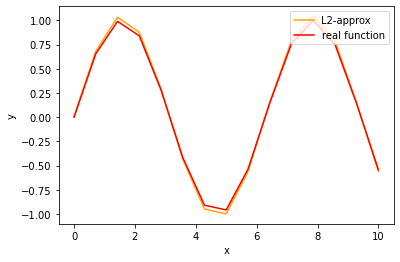

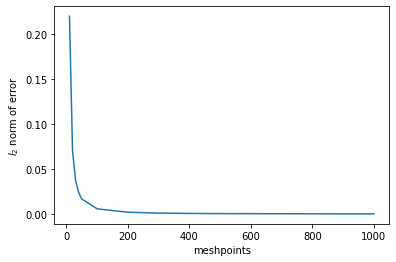

In [11]:

if __name__ == '__main__':
  dim = 1
  meshdim = 15
  mesh = meshgen(dim,meshdim)
  fsquare = lambda x: x*x
  f = lambda x: np.sin(x)
  O = L2(mesh,meshdim,dim)  
  alpha = O.l2projection(f)

  plt.plot(mesh,alpha,'orange',label='L2-approx')
  plt.plot(mesh,f(mesh),'r',label = 'real function')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend(loc='upper right')
  er = alpha-f(mesh)
  print('error: ' + str(er))
  conv = []
  meshdimensions = [10,20,30,40,50,100,200,300,400,500,1000]
  for i in range(len(meshdimensions)):
    dim = 1
    meshdim = meshdimensions[i]
    mesh = meshgen(dim,meshdim)
    fsquare = lambda x: x*x
    f = lambda x: np.sin(x)
    O = L2(mesh,meshdim,dim)  
    alpha = O.l2projection(f)
    er = norm(alpha-f(mesh))
    #er = np.average(alpha-f(mesh))
    conv.append(er)
  plt.figure(2)
  plt.xlabel('meshpoints')
  plt.ylabel('$l_2$ norm of error')
  plt.plot(meshdimensions,conv)
  
  dim = 1
  meshdim = 15
  mesh = meshgen(dim,meshdim)
  fsquare = lambda x: x*x
  f = lambda x: np.sin(x)
  O = L2(mesh,meshdim,dim)  
  alpha = O.l2projection(f)
  
  #L2 in 2D
  #dim = 2
  #meshdim = 10
  #mesh = meshgen(dim,meshdim)
  #axes = Axes3D(plt.figure())




To solve the Poiosson equation I tried out a basis function $v_i = x^{i+1}$ since we require that $v_i(0) = v_i(1) = 0 $due to the fact that $u$ is defined and $u(0) = 0$ there.

After solving and going through the variational formulation I ended up with:

$b_i = \int^1_0 f(x) v_i dx$

with $f(x) = sin(x)$


$a_{ij} = \int^1_0 v_j'(x)v_i(x)dx = [\frac{(i+1)x^(2i)}{2i+1}]^1_0$



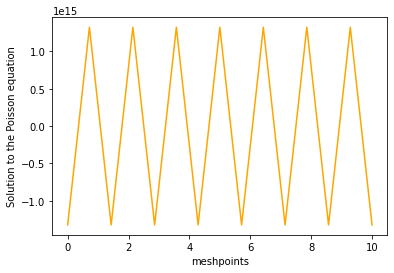

In [12]:
class L2_Poisson:

  def __init__(self, mesh,n,dim):
    self.mesh = mesh
    self.dim = dim
    self.n = n
    self.globalM = np.zeros((n,n))
    self.globalb = np.zeros((n))

  def assemble_system(self, f):
    if self.dim == 1:
      for k in range(0,self.n-1):
        q = 1 #number of quadrature points
        A = np.zeros((q+1,q+1))
        b = np.zeros((q+1))
        for i in range(q+1):
          b[i] = self.integrate_vector(f,k,i)
          for j in range(q+1):
            A[i,j] = self.integrate_matrix(k,i,j)
        self.add_to_global_vector(b,k)
        self.add_to_global_matrix(A,k)


  def integrate_matrix(self,k, i, j):
    return integrate.quad(lambda x: (1+i)*x**(2*i+1), self.mesh[k], self.mesh[k+1])[0]


  def integrate_vector(self, f, k, i):
    return integrate.quad(lambda x: f(x) * x**(i+1), self.mesh[k], self.mesh[k+1])[0]

  def add_to_global_vector(self, b, k):
    self.globalb[k] += b[0]
    self.globalb[k+1] += b[1]
                
  def add_to_global_matrix(self, A, k):
    self.globalM[k,k] += A[0,0]
    self.globalM[k,k+1] += A[0,1]
    self.globalM[k+1,k] += A[1,0]
    self.globalM[k+1,k+1] = +A[1,1]

  def l2projection(self,f):
    self.assemble_system(f)
    return np.linalg.solve(self.globalM, self.globalb)

def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS
if __name__ == '__main__':

  dim = 1
  meshdim = 15
  mesh = meshgen(dim,meshdim)
  f = lambda x: np.sin(x)
  O = L2_Poisson(mesh,meshdim,dim)  
  alpha = O.l2projection(f)
  plt.plot(mesh,alpha,'orange',label='L2-approx')
  #plt.plot(mesh,f(mesh),'r',label = 'real function')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.xlabel('meshpoints')
  plt.ylabel('Solution to the Poisson equation')
  #mesh = UnitSquareMesh(meshdim, 0)
  #V = FunctionSpace(mesh, "Lagrange", 1)
  #u0 = Constant(0.0)
  #bc = DirichletBC(V, u0, boundary)
  #u = TrialFunction(V)
  #v = TestFunction(V)
  #f = Expression("sin(x[0])")
  #g = Expression("0*x[0]")
  #a = inner(grad(u), grad(v))*dx
  #L = f*v*dx + g*v*ds
  #u = Function(V)
  #solve(a == L, u, bc)
  #print(u)
  

# **Discussion**

Regarding the comparison for the Poisson problem I tried to install fenics but had some issues with importing Dolfin.

I worked quite alot to try to solve the 2dim problem.  But I didn't figure out a nice way to integrate over the mesh yet. Maybe I learn a nice method next week :) I would be awesome to learn how the methods for 3d. I believe though that they are pretty similar to the 2d case.